# 2: Spherical wind
-------------------


In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.core     as magritte

from astropy import units, constants

In [2]:
# Define names for the data files
model_file = 'output/magritte_spherical_wind.hdf5'
lamda_file = 'data/co_cut_20.txt'
output_file = 'output/WX_Psc_model_results.txt'

# Make file to store results, if it doesn't already exist
try:
    with open(output_file, 'x') as f:
        f.write('Mdot, epsilon, chi2\n')
except FileExistsError:
    print('This file already exists, good!')

This file already exists, good!


You will modify two parameters to find the best fit model: the mass-loss rate and the power-law exponent of the temperature profile

In [3]:
# Define the mass-loss rate (Mdot, in solar masses per year) and temperature profile exponent (epsilon)
Mdot     = 5e-6
epsilon  =  0.5

In [4]:
# Now define the other stellar parameters we will need
distance = (740     * units.pc            ).si.value  # distance to WX Psc
r_star   = (520     * constants.R_sun     ).si.value  # stellar radius
r_in     =  1.7     * r_star                          # radius of the inner edge of the circumstellar envelope
r_out    = (1.1e+17 * units.cm            ).si.value  # radius of the outer edge of the circumstellar envelope
v_inf    = (19.8    * units.km/units.s    ).si.value  # expansion velocity of the envelope
T_star   = (2750    * units.K             ).si.value  # effective temperature of the star
T_in     = (1000    * units.K             ).si.value  # temperature at r_in = dust condensation temperature
xCO      =  1.0e-4                                    # fractional CO abundance (relative to H2)
v_turb   = (1.5e+0  * units.km   /units.s ).si.value  # turbulent velocity

# Give Mdot in SI units
Mdot_si = (Mdot  * units.M_sun/units.yr).si.value

# Define the number and array of radial points
npoints  = 512
rs = np.logspace(np.log10(r_in), np.log10(r_out), npoints, dtype=np.float64)

# Define the other arrays
v_r = v_inf  * np.ones_like(rs)                 # expansion velocity
trb = v_turb * np.ones_like(rs)                 # turbulent velocity
tmp = T_in * (r_in / rs)**epsilon               # temperature
rho = Mdot_si / (4.0 * np.pi * rs**2 * v_r)     # density
nH2 = (constants.N_A.si.value / 2.02e-3) * rho  # H2 density
nCO = xCO * nH2                                 # CO density

In [5]:
# Set up a spherically symmetric Magritte model with the parameters defined above
model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_model_name        (model_file)
model.parameters.set_dimension         (1)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (48)
model.parameters.set_nspecs            (3)
model.parameters.set_nlspecs           (1)
model.parameters.set_nquads            (11)
model.parameters.pop_prec              =1e-4

model.geometry.points.position.set([[r,                      0, 0] for r in rs])
model.geometry.points.velocity.set([[v/constants.c.si.value, 0, 0] for v in v_r])

model.chemistry.species.abundance = [[CO, H2, 0.0] for (CO, H2) in zip(nCO, nH2)]
model.chemistry.species.symbol    = ['CO', 'H2', 'e-']

model.thermodynamics.temperature.gas  .set( tmp                         )
model.thermodynamics.turbulence.vturb2.set((trb/constants.c.si.value)**2)

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file)
model = setup.set_quadrature              (model)

# Write and read model to initialize all variables
model.write()
model.read ()

IndexError: list index out of range

In [7]:
# Initialize model with LTE level populations
model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

Computing spectral discretisation...
Computing inverse line widths...
Computing LTE level populations...


0

In [ ]:
# Iterate level populations until statistical equilibrium
model.compute_level_populations_sparse (True, 200)

In [35]:
# Define the different lines by name, line number, and beam FWHM in arcsec (for the APEX telescope)
lines = {'CO32':[2, 17.3], 'CO43':[3, 13.3], 'CO76':[6, 7.7]}

# Define the radial velocity of the source (in km/s) so we can shift the model spectrum by this amount
v_rad = 9.0

# Define a function to calculate chi2
def chi2_calc(data_flux, model_flux, sigma):
    data_flux = np.array(data_flux)
    model_flux = np.array(model_flux)
    sigma = np.array(sigma)
    chi2 = np.sum((model_flux-data_flux)**2/sigma**2)
    return chi2

In [36]:
# Extract spectra from the model for each CO transition
for line in lines:
    line_nr = lines[line][0]
    FWHM = lines[line][1] * units.arcsec
    velo, flux_density = np.loadtxt('data/WX_Psc_{}_Jy.dat'.format(line), unpack=True)
    mask = np.logical_and(velo > -42.0, velo < 60.0)
    nfreqs = len(velo[mask])   # number of velocity elements (same as data)
    vpix   = (velo[1]-velo[0])*1e3   # velocity pixel size [m/s]
    fcen = model.lines.lineProducingSpecies[0].linedata.frequency[line_nr]  # rest frequency of the given transition
    dd   = vpix * (nfreqs-1)/2 / magritte.CC
    fmin = fcen - fcen*dd
    fmax = fcen + fcen*dd

    model.compute_spectral_discretisation(fmin, fmax, nfreqs)
    model.compute_image(model.parameters.hnrays()-1)
    
    # Extract the image data from Magritte
    image_nr = -1
    imx = np.array(model.images[image_nr].ImX)
    imI = np.array(model.images[image_nr].I)

    # Calculate integration weights and convert to Jansky from SI units
    b  = imx # impact factors
    b0 = np.concatenate(([0.0], b))
    ds = np.pi * (b0[1:] - b0[:-1]) * (b0[1:] + b0[:-1]) / distance**2 / 1.0e-26

    # Calculate beam to convolve with model intensities
    FWHM_m = ((FWHM * (distance * units.meter).to(units.parsec)) * units.au).si.value  # convert to meters
    sigma  = FWHM_m / (2.0 * np.sqrt(2.0 * np.log(2)))
    beam   = np.exp(-0.5*(b/sigma)**2) / (np.sqrt(2.0 * np.pi) * sigma)
    beam   = beam / beam[0]  
    
    # Calculate intensity (flux density in Jy)
    I_no_beam  = np.einsum('if, i -> f', imI,        ds)  # total model intensity without taking the beam into account
    I          = np.einsum('if, i -> f', imI, beam * ds)  # model intensity as seen with a beam size of <FWHM>
    
    # Calculate frequencies and hence velocities
    freqs = np.array(model.radiation.frequencies.nu)[0]
    velos = (freqs - fcen) / fcen * magritte.CC / 1.0e3
    
    # Save output spectrum
    with open('output/WX_Psc_model_{}_Mdot{}_epsilon{}.dat'.format(line, Mdot, epsilon), 'w+') as f:
        f.write('#Velocity(km/s),FluxDensity(Jy)\n')
        for i in range(len(velos)):
            f.write('{} {}\n'.format(velos[i], I[i]))

Computing spectral discretisation...
Computing image...
Computing spectral discretisation...
Computing image...
Computing spectral discretisation...
Computing image...


Now plot the output model spectra against the data, and calculate the $\chi^2$ value for goodness of fit

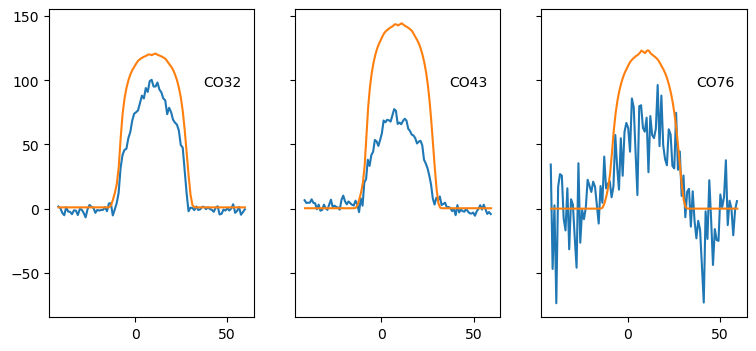

In [41]:
# Define empty lists to add values for the chi2 calculation
data_flux  = []
model_flux = []
sigma = []

# Plot all three lines with data vs model
fig, axs = plt.subplots(1, 3, figsize=(9,4), sharey='row')
for i, line in enumerate(lines):
    # Read in data for the given line
    velo, flux_density = np.loadtxt('data/WX_Psc_{}_Jy.dat'.format(line), unpack=True)
    mask = np.logical_and(velo > -42.0, velo < 60.0)
    data_flux += list(flux_density[mask])
    rms = np.std(flux_density[:100])
    sigma += list(rms*np.ones(len(flux_density[mask])))
    
    # Read in model for the given line
    velo_model, intensity = np.loadtxt('output/WX_Psc_model_{}_Mdot{}_epsilon{}.dat'.format(line, Mdot, epsilon), unpack=True)
    model_flux += list(intensity)
    
    # Plot
    axs[i].plot(velo[mask], flux_density[mask], label='data')
    axs[i].plot(velo_model+v_rad, intensity, label='model')
    axs[i].text(37, 95, line)


In [44]:
# Calculate chi2 and add the result of these particular parameters to the output file
chi2 = chi2_calc(data_flux, model_flux, sigma)
with open(output_file, 'a') as f:
    f.write('{}, {}, {}\n'.format(Mdot, epsilon, chi2))

NameError: name 'chi2_calc' is not defined